# Setup

## Config

In [1]:
INPUT_DATASET = 'layoric/labeled-multiple-choice-explained'
REVISION = '536f3b8'
OUTPUT_DATASET = 'derek-thomas/labeled-multiple-choice-explained-mistral-reasoning'
NAMESPACE = 'HF-test-lab' # Use your username or wherever you have the ability to deploy inference endpoints

In [2]:
from transformers import AutoTokenizer
from huggingface_hub import get_token, login

login()

In [3]:
BASE_MODEL = 'mistralai/Mistral-7B-Instruct-v0.3'
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, token=get_token())

# Mistral Prompt Creation

In [4]:
import pandas as pd
from datasets import load_dataset
import json

## Load and Cleanup Dataset

In [5]:
# Load dataset from Hugging Face Hub
dataset = load_dataset(INPUT_DATASET, split='train', revision=REVISION)

# Convert to pandas dataframe
df = dataset.to_pandas()

In [6]:
df

formatted_question  \
0     what is satellite technology used for predicti...   
1     what does irradiating food do? (a) relieve pai...   
2     what protects a mammal's skin? (a) fiber folli...   
3     what do earthworms do when a segment breaks of...   
4     lightning can be bad for what? (a) the environ...   
...                                                 ...   
9093  organisms that can cause infection do what? (a...   
9094   fungi are living things that cannot make thei...   
9095  an overheated body can use water for: (a) meta...   
9096  what is essential for cellular respiration for...   
9097  what helps insulate and protect the body? (a) ...   

                                           combinedfact answerKey  \
0     satellite technology is used for predicting wh...         c   
1                 irradiated food improves food safety.         c   
2                   fiber follicles protect mammal skin         a   
3         earthworms can regrow segments that break off         b   
4             lightning can be bad for the environment.         a   
...                                                 ...       ...   
9093  organisms that can cause infection make humans...         g   
9094  fungi are living things that cannot make their...         a   
9095  the evaporation of water from the skin cools t...         g   
9096  plants are essential for cellular respiration ...         f   
9097  living cells in follicles help insulate and pr...         b   

             topic  __index_level_0__  \
0       technology            35972.0   
1     food science            20412.0   
2          biology             5779.0   
3          biology             4064.0   
4      electricity            34080.0   
...            ...                ...   
9093       biology            33485.0   
9094       biology            12097.0   
9095       biology             6522.0   
9096       biology            27144.0   
9097       biology            18522.0   

                                            explanation  
0     a) Seconds and minutes: This option is incorre...  
1     (a) Relieve pain: This option is not correct b...  
2     b) Exfoliation: Exfoliation is the process of ...  
3     a) Dies: This option is not correct because ea...  
4     b) Rainstorms: Lightning is actually a natural...  
...                                                 ...  
9093  a) Bandaging open sores is not the correct ans...  
9094  b) Fungi are living things that can make their...  
9095  a) Metabolic reaction: This option is incorrec...  
9096  a) Electrons are involved in cellular respirat...  
9097  a) H2O: Water is essential for life, but it do...  

[9098 rows x 6 columns]

In [7]:
print(f"Before Cleaning: {len(df)} rows")

# Drop the __index_level_0__ column if it exists
df.drop(columns=['__index_level_0__'], errors='ignore', inplace=True)

# Ensure all values in 'formatted_question' are strings
df['formatted_question'] = df['formatted_question'].astype(str)

# Filter on topic so that we can stratify later
df['topic'] = df['topic'].fillna('unknown')
topic_counts = df['topic'].value_counts()
valid_topics = topic_counts[topic_counts >= 5].index
df = df[df['topic'].isin(valid_topics)]
df = df[~df['topic'].isin(['unknown'])]

df.rename(columns={
    'combinedfact': 'combined_fact',
    'answerKey': 'answer_key' 
}, inplace=True)


# Drop the index level 0 if it exists
df.reset_index(drop=True, inplace=True)
print(f"After Cleaning: {len(df)} rows")

Before Cleaning: 9098 rows
After Cleaning: 8413 rows


In [8]:
df

formatted_question  \
0     what is satellite technology used for predicti...   
1     what does irradiating food do? (a) relieve pai...   
2     what protects a mammal's skin? (a) fiber folli...   
3     what do earthworms do when a segment breaks of...   
4     lightning can be bad for what? (a) the environ...   
...                                                 ...   
8408  organisms that can cause infection do what? (a...   
8409   fungi are living things that cannot make thei...   
8410  an overheated body can use water for: (a) meta...   
8411  what is essential for cellular respiration for...   
8412  what helps insulate and protect the body? (a) ...   

                                           combinedfact answer_key  \
0     satellite technology is used for predicting wh...          c   
1                 irradiated food improves food safety.          c   
2                   fiber follicles protect mammal skin          a   
3         earthworms can regrow segments that break off          b   
4             lightning can be bad for the environment.          a   
...                                                 ...        ...   
8408  organisms that can cause infection make humans...          g   
8409  fungi are living things that cannot make their...          a   
8410  the evaporation of water from the skin cools t...          g   
8411  plants are essential for cellular respiration ...          f   
8412  living cells in follicles help insulate and pr...          b   

             topic                                        explanation  
0       technology  a) Seconds and minutes: This option is incorre...  
1     food science  (a) Relieve pain: This option is not correct b...  
2          biology  b) Exfoliation: Exfoliation is the process of ...  
3          biology  a) Dies: This option is not correct because ea...  
4      electricity  b) Rainstorms: Lightning is actually a natural...  
...            ...                                                ...  
8408       biology  a) Bandaging open sores is not the correct ans...  
8409       biology  b) Fungi are living things that can make their...  
8410       biology  a) Metabolic reaction: This option is incorrec...  
8411       biology  a) Electrons are involved in cellular respirat...  
8412       biology  a) H2O: Water is essential for life, but it do...  

[8413 rows x 5 columns]

## Process and Format Questions and Answer Choices
I do some minor cleaning since the original dataset is a bit messy.

In [9]:
# Split before the first occurrence of "(a)" to separate question and answer choices
df['topic'] = df['topic'].str.capitalize()
df['question_text'] = df['formatted_question'].str.extract(r'^(.*?)(?=\(a\)|$)')[0]
df['answer_choices'] = df['formatted_question'].str.extract(r'(\(a\).*)$')[0]

# Function to check if the text needs a question mark
def add_question_mark_if_needed(text):
    text = text.strip().capitalize()
    if not text.endswith('?'):
        return text + '?'
    return text

# Apply the function to the 'question_text' column
df['question_text'] = df['question_text'].apply(add_question_mark_if_needed)

# Function to capitalize each answer choice item
def capitalize_answer_choices(answer_choices):
    import re
    pattern = r'\(([a-z])\)\s*([^\(]+)'
    matches = re.findall(pattern, answer_choices)
    capitalized_choices = []
    for match in matches:
        label, text = match
        capitalized_choices.append(f'({label}) {text.strip().capitalize()}')
    return ' '.join(capitalized_choices)

# Apply function to format answer choices
df['answer_choices'] = df['answer_choices'].apply(capitalize_answer_choices)

In [10]:
df

formatted_question  \
0     what is satellite technology used for predicti...   
1     what does irradiating food do? (a) relieve pai...   
2     what protects a mammal's skin? (a) fiber folli...   
3     what do earthworms do when a segment breaks of...   
4     lightning can be bad for what? (a) the environ...   
...                                                 ...   
8408  organisms that can cause infection do what? (a...   
8409   fungi are living things that cannot make thei...   
8410  an overheated body can use water for: (a) meta...   
8411  what is essential for cellular respiration for...   
8412  what helps insulate and protect the body? (a) ...   

                                           combinedfact answer_key  \
0     satellite technology is used for predicting wh...          c   
1                 irradiated food improves food safety.          c   
2                   fiber follicles protect mammal skin          a   
3         earthworms can regrow segments that break off          b   
4             lightning can be bad for the environment.          a   
...                                                 ...        ...   
8408  organisms that can cause infection make humans...          g   
8409  fungi are living things that cannot make their...          a   
8410  the evaporation of water from the skin cools t...          g   
8411  plants are essential for cellular respiration ...          f   
8412  living cells in follicles help insulate and pr...          b   

             topic                                        explanation  \
0       Technology  a) Seconds and minutes: This option is incorre...   
1     Food science  (a) Relieve pain: This option is not correct b...   
2          Biology  b) Exfoliation: Exfoliation is the process of ...   
3          Biology  a) Dies: This option is not correct because ea...   
4      Electricity  b) Rainstorms: Lightning is actually a natural...   
...            ...                                                ...   
8408       Biology  a) Bandaging open sores is not the correct ans...   
8409       Biology  b) Fungi are living things that can make their...   
8410       Biology  a) Metabolic reaction: This option is incorrec...   
8411       Biology  a) Electrons are involved in cellular respirat...   
8412       Biology  a) H2O: Water is essential for life, but it do...   

                                          question_text  \
0     What is satellite technology used for predicting?   
1                        What does irradiating food do?   
2                        What protects a mammal's skin?   
3      What do earthworms do when a segment breaks off?   
4                        Lightning can be bad for what?   
...                                                 ...   
8408        Organisms that can cause infection do what?   
8409  Fungi are living things that cannot make their...   
8410             An overheated body can use water for:?   
8411  What is essential for cellular respiration for...   
8412          What helps insulate and protect the body?   

                                         answer_choices  
0     (a) Seconds and minutes (b) The strength and m...  
1     (a) Relieve pain (b) Enhance food's nutrients ...  
2     (a) Fiber follicles (b) Exfoliation (c) Resist...  
3     (a) Dies (b) Regrows it (c) Reproduces (d) Sed...  
4     (a) The environment (b) Rainstorms (c) Destruc...  
...                                                 ...  
8408  (a) Bandage open sores (b) Keep flesh clean (c...  
8409  (a) Food (b) Cells (c) Energy (d) Fruits (e) H...  
8410  (a) Metabolic reaction (b) Dehydrating (c) Rai...  
8411  (a) Electron (b) Glucose (c) Energy (d) Energy...  
8412  (a) H2o (b) Living cells in follicles (c) Laye...  

[8413 rows x 7 columns]

## Prompt Creation

This is the original prompt from layoric. It looks pretty good, but we need to adjust this for mistral. 
```
{{#role 'system'~}}
You are an AI assistant that helps people find information. User will give you a question. Your task is to answer as faithfully as you can, and most importantly, provide explanation why incorrect answers are not correct. While answering think step-by-step and justify your answer.
{{~/role}}
{{#role 'user'~}}
USER:
Topic: {{topic}}
Question: {{question}}

### Answer
The correct answer is:
{{answer_key}}). {{answer}}

### Explanation:
Let's break it down step by step.

1. Read the question and options carefully.
2. Identify the differences between the options.
3. Determine which options are not logical based on the difference.
4. Go through each incorrect answer providing an explanation why it is incorrect.
{{~/role}}

{{#role 'assistant'~}}
{{~gen 'explanation'}}
{{~/role}}
```
Changes:
1. We need to move the system instructions to the user message
2. Let's rename `explanation` to `reasoning`

We want something like this:

In [11]:
def create_mistral_reasoning_prompt(row):
    reasoning_instructions = f'''You are an AI assistant that helps people find information. User will give you a question and an answer. Your task is to explain your reasoning of the correct answer and provide explanation why incorrect answers are not correct. While answering, think step-by-step and justify your answer.

Topic: {row['topic']}
Question: {row['question_text']}
Answer Choices: {row['answer_choices']}

The correct answer is: ({row['answer_key']})

### Reasoning:
Let's break it down step by step.

1. Read the question and options carefully.
2. Identify the differences between the options.
3. Determine which options are not logical based on the difference.
4. Go through each incorrect answer providing an explanation why it is incorrect.'''
    
    return [{"role": "user", "content": reasoning_instructions}]


Note that I updated the instructions slightly.

In [12]:
df['mistral_reasoning_prompt'] = df.apply(create_mistral_reasoning_prompt, axis=1)
print(df['mistral_reasoning_prompt'].iloc[0])
print('\n---\n')
print(df['mistral_reasoning_prompt'].iloc[0][0]['content'])

[{'role': 'user', 'content': "You are an AI assistant that helps people find information. User will give you a question and an answer. Your task is to explain your reasoning of the correct answer and provide explanation why incorrect answers are not correct. While answering, think step-by-step and justify your answer.\n\nTopic: Technology\nQuestion: What is satellite technology used for predicting?\nAnswer Choices: (a) Seconds and minutes (b) The strength and magnitude of an earthquake (c) What it's like outside each day (d) 70-75 degrees fahrenheit (e) Rapid changes occur (f) Dead-ends and false starts. (g) Snow, ice, and rock (h) Around 5 to 27 degrees celsius\n\nThe correct answer is: (c)\n\n### Reasoning:\nLet's break it down step by step.\n\n1. Read the question and options carefully.\n2. Identify the differences between the options.\n3. Determine which options are not logical based on the difference.\n4. Go through each incorrect answer providing an explanation why it is incorrec

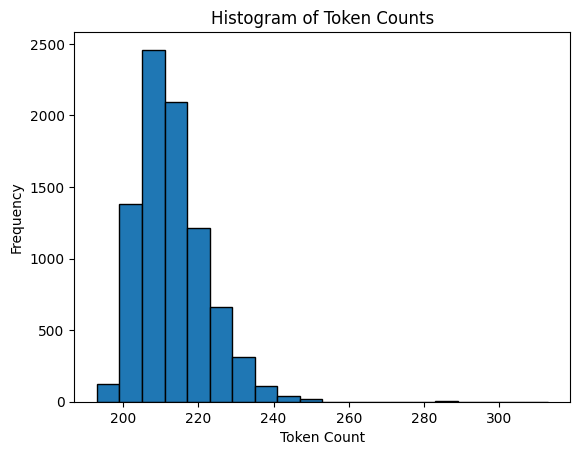

313 193


In [13]:
import matplotlib.pyplot as plt

token_dist = df['mistral_reasoning_prompt'].apply(lambda x: len(tokenizer.apply_chat_template(x)))

# Plot the histogram of token counts
plt.hist(token_dist, bins=20, edgecolor='black')
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()
print(max(token_dist), min(token_dist))

# Deployment

In [14]:
from huggingface_hub import create_inference_endpoint
from huggingface_hub import get_inference_endpoint


def get_my_endpoint():
    name = f"poe-reasoning"
    namespace=NAMESPACE
    try:
        endpoint = get_inference_endpoint(name, namespace=namespace)
        endpoint.wait()
    except:
        # Custom Docker image details
        custom_image = {
            "health_route": "/health",
            "url": "ghcr.io/huggingface/text-generation-inference:2.4.1",  # This is the min version
            "env": {
                # "LORA_ADAPTERS": "derek-thomas/autotrain-mistral-v03-prompt-experiment-mc-FA-sg,derek-thomas/autotrain-mistral-v03-prompt-experiment-mc-FA-R-sg,derek-thomas/autotrain-mistral-v03-prompt-experiment-mc-FA-sg",  # Add adapters here
                "MAX_BATCH_PREFILL_TOKENS": "8192",
                "MAX_INPUT_TOKENS": "320", # Set according to your needs
                "MAX_TOTAL_TOKENS": "2000", # Set according to your needs
                "DISABLE_CUSTOM_KERNELS": 'false',
                "MODEL_ID": "/repository"
            },
        }
        
        secrets = {
            "HF_TOKEN": get_token()
        }
        
        # Creating the inference endpoint
        endpoint = create_inference_endpoint(
            name=name,
            namespace=namespace,
            repository='mistralai/Mistral-7B-Instruct-v0.3',
            framework="pytorch",
            accelerator="gpu",
            instance_size="x1",
            instance_type="nvidia-l4",
            region="us-east-1",
            vendor="aws",
            min_replica=4,
            max_replica=4,
            task="text-generation",
            custom_image=custom_image,
            secrets=secrets
        )
        # endpoint.wait()
            
    print("Your model is ready to use!")
    endpoint.wait()
    return endpoint

In [15]:
endpoint = get_my_endpoint()

Your model is ready to use!


In [16]:
response = endpoint.client.chat_completion(df['mistral_reasoning_prompt'].iloc[0], max_tokens=1650)
response.choices[0].message.content

'(a) Seconds and minutes: Satellite technology is not used for predicting seconds or minutes with precision. While atomic clocks on satellites help keep time for GPS, they are not used for predicting seconds or minutes in the general sense.\n\n(b) The strength and magnitude of an earthquake: While satellite technology can detect earthquakes based on changes in ground motion, it is not used to predict earthquakes accurately. The movements of tectonic plates are not predictable with sufficient certainty to allow for accurate earthquake prediction.\n\n(d) 70-75 degrees fahrenheit: Satellite technology is not used to predict temperature in this specific range. Satellites can help monitor and predict temperature variations globally, but they cannot target a specific temperature range, especially one as narrow as 70-75°F.\n\n(e) Rapid changes occur: Satellite technology is not applicable to predict rapid changes in general, as they may refer to various phenomena, not just those related to sa

In [17]:
import nest_asyncio
import asyncio
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

# Assuming 'endpoint' and 'df' are already defined

nest_asyncio.apply()

async def async_chat_completion(prompt, max_tokens=1650):
    response = await endpoint.async_client.chat_completion(prompt, max_tokens=max_tokens)
    return response.choices[0].message.content

async def generate_mistral_reasoning(prompts, max_tokens=1650, num_workers=64):
    loop = asyncio.get_event_loop()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        tasks = [loop.run_in_executor(executor, lambda p=prompt: asyncio.run(async_chat_completion(p, max_tokens))) for prompt in prompts]
        results = []
        with tqdm(total=len(tasks), desc="Processing Prompts") as pbar:
            for result in asyncio.as_completed(tasks):
                results.append(await result)
                pbar.update(1)
        return results

prompts = df['mistral_reasoning_prompt'].tolist()
mistral_reasonings = await generate_mistral_reasoning(prompts)
df['mistral_reasoning'] = mistral_reasonings


Processing Prompts:   0%|          | 0/8413 [00:00<?, ?it/s]

In [18]:
endpoint.pause()

InferenceEndpoint(name='poe-reasoning', namespace='HF-test-lab', repository='mistralai/Mistral-7B-Instruct-v0.3', status='paused', url=None)

In [19]:
df.mistral_reasoning

0       Incorrect answers and explanations:\n\n1. Elec...
1       Sure, let's examine each answer and justify wh...
2       Sure, let's go through each of the provided an...
3       1. Reading the question carefully, we can see ...
4       1. Food: While essential for the growth and he...
                              ...                        
8408    1. Read the question and options carefully: Th...
8409    1. Read the question and options carefully: Th...
8410    1. Read the question and options carefully: Th...
8411    1. First, let's read the question and options ...
8412    1. Read the question and options carefully: Th...
Name: mistral_reasoning, Length: 8413, dtype: object

In [25]:
df

formatted_question  \
0     what is satellite technology used for predicti...   
1     what does irradiating food do? (a) relieve pai...   
2     what protects a mammal's skin? (a) fiber folli...   
3     what do earthworms do when a segment breaks of...   
4     lightning can be bad for what? (a) the environ...   
...                                                 ...   
8408  organisms that can cause infection do what? (a...   
8409   fungi are living things that cannot make thei...   
8410  an overheated body can use water for: (a) meta...   
8411  what is essential for cellular respiration for...   
8412  what helps insulate and protect the body? (a) ...   

                                          combined_fact answer_key  \
0     satellite technology is used for predicting wh...          c   
1                 irradiated food improves food safety.          c   
2                   fiber follicles protect mammal skin          a   
3         earthworms can regrow segments that break off          b   
4             lightning can be bad for the environment.          a   
...                                                 ...        ...   
8408  organisms that can cause infection make humans...          g   
8409  fungi are living things that cannot make their...          a   
8410  the evaporation of water from the skin cools t...          g   
8411  plants are essential for cellular respiration ...          f   
8412  living cells in follicles help insulate and pr...          b   

             topic                                        explanation  \
0       Technology  a) Seconds and minutes: This option is incorre...   
1     Food science  (a) Relieve pain: This option is not correct b...   
2          Biology  b) Exfoliation: Exfoliation is the process of ...   
3          Biology  a) Dies: This option is not correct because ea...   
4      Electricity  b) Rainstorms: Lightning is actually a natural...   
...            ...                                                ...   
8408       Biology  a) Bandaging open sores is not the correct ans...   
8409       Biology  b) Fungi are living things that can make their...   
8410       Biology  a) Metabolic reaction: This option is incorrec...   
8411       Biology  a) Electrons are involved in cellular respirat...   
8412       Biology  a) H2O: Water is essential for life, but it do...   

                                          question_text  \
0     What is satellite technology used for predicting?   
1                        What does irradiating food do?   
2                        What protects a mammal's skin?   
3      What do earthworms do when a segment breaks off?   
4                        Lightning can be bad for what?   
...                                                 ...   
8408        Organisms that can cause infection do what?   
8409  Fungi are living things that cannot make their...   
8410             An overheated body can use water for:?   
8411  What is essential for cellular respiration for...   
8412          What helps insulate and protect the body?   

                                         answer_choices  \
0     (a) Seconds and minutes (b) The strength and m...   
1     (a) Relieve pain (b) Enhance food's nutrients ...   
2     (a) Fiber follicles (b) Exfoliation (c) Resist...   
3     (a) Dies (b) Regrows it (c) Reproduces (d) Sed...   
4     (a) The environment (b) Rainstorms (c) Destruc...   
...                                                 ...   
8408  (a) Bandage open sores (b) Keep flesh clean (c...   
8409  (a) Food (b) Cells (c) Energy (d) Fruits (e) H...   
8410  (a) Metabolic reaction (b) Dehydrating (c) Rai...   
8411  (a) Electron (b) Glucose (c) Energy (d) Energy...   
8412  (a) H2o (b) Living cells in follicles (c) Laye...   

                               mistral_reasoning_prompt  \
0     [{'role': 'user', 'content': 'You are an AI as...   
1     [{'role': 'user', 'content': 'You are an AI as...   
2     [{'role':

In [26]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset.push_to_hub(OUTPUT_DATASET)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/derek-thomas/labeled-multiple-choice-explained-mistral-reasoning/commit/f6554f7b3e0671558956eed6a42453b281b6f7e8', commit_message='Upload dataset', commit_description='', oid='f6554f7b3e0671558956eed6a42453b281b6f7e8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/derek-thomas/labeled-multiple-choice-explained-mistral-reasoning', endpoint='https://huggingface.co', repo_type='dataset', repo_id='derek-thomas/labeled-multiple-choice-explained-mistral-reasoning'), pr_revision=None, pr_num=None)